In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import math
import numpy as np

from yellowbrick.regressor import ResidualsPlot

##  Carrega dados

In [2]:
df = pd.read_csv("data/apartamentos_completo_intermediario.csv")
df = df.drop(['Unnamed: 0'],axis=1)
print(df.shape)
df.head()

(29001, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89m²,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras",", Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224m²,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília",", Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65m²,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,", Asa Norte, Brasília",9
3,"01, 02 QUARTOS E LOJA COMERCIAL - MEET NOROESTE",332420,https://www.wimoveis.com.br/propriedades/01-02...,NaN,NaN,-15.748856500000000,-47.896520000000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117m²,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília",", Park Sul, Brasília",8


In [3]:
df.dtypes

nome              object
valor_venda        int64
url               object
condominio        object
IPTU              object
lat               object
long              object
area_total        object
area_util         object
banheiros        float64
vagas            float64
quartos          float64
suites           float64
idade             object
endereco          object
bairro            object
idade_anuncio     object
dtype: object

### Dropa imoveis que não tem latitude, longitude e área útil

In [4]:
df.dropna(subset=['lat', 'long','area_util'],inplace=True)

### Quantidade de valores nulos por coluna

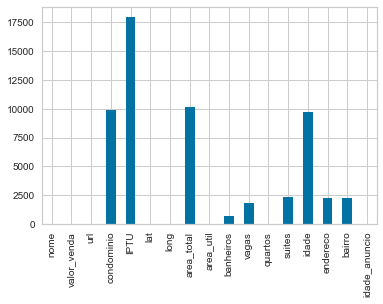

In [5]:
df.isna().sum().plot.bar()

In [6]:
df.isna().sum()

nome                 0
valor_venda          0
url                  0
condominio        9852
IPTU             17920
lat                  0
long                 0
area_total       10122
area_util            0
banheiros          714
vagas             1805
quartos             26
suites            2368
idade             9720
endereco          2254
bairro            2254
idade_anuncio        0
dtype: int64

### Remove outliers do preço de venda

In [7]:
print(df.shape)
df.valor_venda.describe()

(26414, 17)


count    2.641400e+04
mean     2.649756e+06
std      6.130884e+07
min      5.500000e+01
25%      2.700000e+05
50%      4.700000e+05
75%      9.800000e+05
max      6.299000e+09
Name: valor_venda, dtype: float64

### 6 bilhões parece muito para um imóvel
Vamos remover aqueles que custam a partir de 65 milhões

In [8]:
df = df.loc[df.valor_venda < 65000000]
print(df.shape)
df.valor_venda.describe()

(26331, 17)


count    2.633100e+04
mean     7.370099e+05
std      7.595369e+05
min      5.500000e+01
25%      2.693900e+05
50%      4.600000e+05
75%      9.800000e+05
max      1.200000e+07
Name: valor_venda, dtype: float64

### Checa distribuição dos Bairros

In [9]:
df.bairro = df.bairro.str.replace(",  ","")
df.bairro.value_counts()

Aguas Sul, Águas Claras                                 3218
Noroeste, Brasília                                      3092
Aguas Norte, Águas Claras                               2954
Asa Norte, Brasília                                     2851
Asa Sul, Brasília                                       2047
Sudoeste, Brasília                                      1426
Taguatinga Norte, Taguatinga                             783
Park Sul, Brasília                                       675
Guara II, Guará                                          610
Samambaia Sul, Samambaia                                 501
Lago Norte, Brasília                                     443
Areal, Águas Claras                                      432
Setor Marista, Goiânia                                   432
Taguatinga Sul, Taguatinga                               423
Setor Bueno, Goiânia                                     391
Guara I, Guará                                           261
Samambaia Norte, Samamba

In [10]:
bairros_goiania = ['Setor Bueno, Goiânia','Setor Marista, Goiânia','Jardim Goiás, Goiânia','Setor Oeste, Goiânia',
                  'Parque Amazônia, Goiânia','Jardim América, Goiânia']
df = df[~df['bairro'].isin(bairros_goiania)]
df.bairro.value_counts()

Aguas Sul, Águas Claras                                 3218
Noroeste, Brasília                                      3092
Aguas Norte, Águas Claras                               2954
Asa Norte, Brasília                                     2851
Asa Sul, Brasília                                       2047
Sudoeste, Brasília                                      1426
Taguatinga Norte, Taguatinga                             783
Park Sul, Brasília                                       675
Guara II, Guará                                          610
Samambaia Sul, Samambaia                                 501
Lago Norte, Brasília                                     443
Areal, Águas Claras                                      432
Taguatinga Sul, Taguatinga                               423
Guara I, Guará                                           261
Samambaia Norte, Samambaia                               252
Cruzeiro Novo, Cruzeiro                                  212
Centro, Brasília        

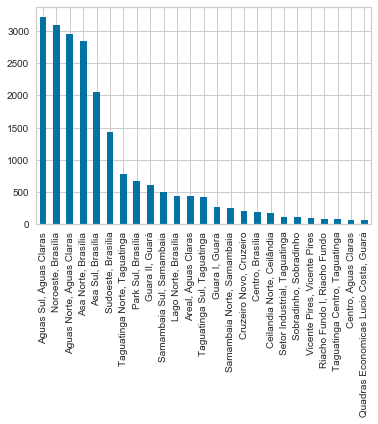

In [11]:
df.bairro.value_counts()[:25].plot.bar()

### Remove bairros com menos imóveis (pega so 25 +)

In [14]:
df.bairro.value_counts()[25:]

Octogonal, Brasília                                     57
Nucleo Bandeirante, Núcleo Bandeirante                  56
Águas Claras, Distrito Federal                          39
QE Lucio Costa, Guará                                   39
Setor Central, Gama                                     38
Setor Industrial, Gama                                  38
Centro, Taguatinga                                      38
Grande Colorado, Sobradinho                             38
Setor Nova Suiça, Goiânia                               36
Setor Bela Vista, Goiânia                               35
Setor Pedro Ludovico, Goiânia                           32
Ceilandia Sul, Ceilândia                                32
Setor Leste Universitário, Goiânia                      31
Samambaia, Samambaia                                    31
Setor Central, Goiânia                                  27
Alto da Glória, Goiânia                                 27
Turista I, Caldas Novas                                 

In [16]:
bairros_reject = df.bairro.value_counts()[25:].index.values
bairros_reject

array(['Octogonal, Brasília', 'Nucleo Bandeirante, Núcleo Bandeirante',
       'Águas Claras, Distrito Federal', 'QE Lucio Costa, Guará',
       'Setor Central, Gama', 'Setor Industrial, Gama',
       'Centro, Taguatinga', 'Grande Colorado, Sobradinho',
       'Setor Nova Suiça, Goiânia', 'Setor Bela Vista, Goiânia',
       'Setor Pedro Ludovico, Goiânia', 'Ceilandia Sul, Ceilândia',
       'Setor Leste Universitário, Goiânia', 'Samambaia, Samambaia',
       'Setor Central, Goiânia', 'Alto da Glória, Goiânia',
       'Turista I, Caldas Novas', 'Riacho Fundo, Riacho Fundo',
       'Parque Esplanada III, Valparaíso de Goiás',
       'Setor de Hotéis e Turismo Norte, Brasília',
       'Zona Industrial, Guará', 'Cruzeiro Velho, Cruzeiro',
       'Lago Sul, Brasília', 'Superquadra Noroeste, Brasília',
       'Parque Esplanada II, Valparaíso de Goiás',
       'Residencial Eldorado, Goiânia', 'Jardim Atlântico, Goiânia',
       'Area Especial, Guará', 'Setor Total Ville, Santa Maria',
       

In [17]:
df = df[~df['bairro'].isin(bairros_reject)]
print(df.shape)
df.head()

(23384, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89m²,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras","Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224m²,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília","Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65m²,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,"Asa Norte, Brasília",9
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117m²,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília","Park Sul, Brasília",8
5,QI 31 Jardins Life Reformadíssimo Localização ...,580000,https://www.wimoveis.com.br/propriedades/qi-31...,NaN,NaN,-15.840017800000000,-47.975002600000038,NaN,68m²,2.0,1.0,2.0,1.0,3,"QUADRA QI 31 LOTES 2/4, Guara II, Guará","Guara II, Guará",6


In [18]:
df.bairro.value_counts()

Aguas Sul, Águas Claras                  3218
Noroeste, Brasília                       3092
Aguas Norte, Águas Claras                2954
Asa Norte, Brasília                      2851
Asa Sul, Brasília                        2047
Sudoeste, Brasília                       1426
Taguatinga Norte, Taguatinga              783
Park Sul, Brasília                        675
Guara II, Guará                           610
Samambaia Sul, Samambaia                  501
Lago Norte, Brasília                      443
Areal, Águas Claras                       432
Taguatinga Sul, Taguatinga                423
Guara I, Guará                            261
Samambaia Norte, Samambaia                252
Cruzeiro Novo, Cruzeiro                   212
Centro, Brasília                          187
Ceilandia Norte, Ceilândia                167
Setor Industrial, Taguatinga              116
Sobradinho, Sobradinho                    108
Vicente Pires, Vicente Pires               96
Riacho Fundo I, Riacho Fundo      

In [20]:
df.tipo.value_counts()

AttributeError: 'DataFrame' object has no attribute 'tipo'

In [ ]:
df.Tipo = df.Tipo.str.replace("\n","")
df = df[df.Tipo != "Rurais"]
df.Tipo.value_counts()

In [ ]:
df.quartos = df.quartos.fillna(df.quartos.median())

In [ ]:
df_regression = df[['Bairro', 'area_total', 'area_util', 'Tipo', 'quartos','venda']]
print(df_regression.shape)
df_regression.head()

In [ ]:
df_regression.isna().sum()

In [ ]:
one_hot = pd.get_dummies(df_regression['Tipo'],prefix="tipo")
df_regression = df_regression.join(one_hot)
df_regression.shape

In [ ]:
df_regression.head()

In [ ]:
one_hot = pd.get_dummies(df_regression['Bairro'], prefix="bairro")
df_regression = df_regression.join(one_hot)

df_regression = df_regression.drop(['Tipo', 'Bairro'], axis=1)

df_regression.shape
df_regression.head()

In [ ]:
X = df_regression.drop(['venda'],axis=1)
y = df_regression['venda']
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
reg = RandomForestRegressor(n_estimators=100) 
reg

In [ ]:
reg.fit(X_train, y_train)
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [ ]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, test_predict))

print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, test_predict)))

print('R2 score: %.2f' % r2_score(y_test, test_predict))

In [ ]:
 plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
reg2 = RandomForestRegressor(n_estimators=100) 

visualizer = ResidualsPlot(reg2)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data